# Hente tabeller med datokonvertering
## Eksempel Nasjonalregnskap
Tabellene for nasjonalregnskap har egenskapen at de har lik struktur men ulik frekvens. Da kan vi enkelt bruke samme spørring, og poste den mot ulike tabellers metadata. for å hente tall
Makroøkonomiske hovedstørrelser:
- [09189](https://www.ssb.no/statbank/table/09189) - årlig
- [09190](https://www.ssb.no/statbank/table/09190) - kvartalsvis
- [11721](https://www.ssb.no/statbank/table/11721) - månedlig



In [1]:
# Her importerer vi ulike pakker

import requests
import pandas as pd
from pyjstat import pyjstat  # pyjstat er for behandling av JSON-stat


URL til tabellenes metadata i PxWebApi, som vi skal poste spørringene mot

In [2]:
tabid = "09190" # prøv å kjøre med id for både år (09189), kvartal (09190)  og måned (11721)
lang = "no"  # vi kan velge "en"
url1 = "https://data.ssb.no/api/v0/" + lang + "/table/" + tabid;

Vi spør etter årlig volumendring for BNP og BNP Fastlandsnorge for perioden 2010-2029 med filter all. 
API-spørring formulert som JSON. 

In [3]:
query1 = {
  "query": [
    {
      "code": "Makrost",
      "selection": {
        "filter": "item",
        "values": [
          "bnpb.nr23_9",
          "bnpb.nr23_9fn"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "Volum"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "all",
        "values": [
         "201*",
          "202*"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}

Generell funksjon for å identifisere frekvens slik at vi kan konvertere til datoformat og sette [**Pandas PeriodIndex**](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-span-representation)

In [4]:
#funksjon for frekvenser
def dateConv(dataframe):
    frekvens, frek_no, frek_en, fmt = findFrequency(dataframe)
    setPeriodIndex(frekvens, frek_no, frek_en, fmt, dataframe)
    
def findFrequency(dataframe):
    frekvenser = ['måned', 'kvartal', 'uke', 'år', 'year', 'quarter', 'month', 'week']
    frek_no = ''  # SSB bruker dessverre norske frekvenskode U - uke osv.
    frek_en = '' # engelsk frekvens kode
    fmt = '' # python datoformat
    for w in frekvenser:
        if w in dataframe.columns:
            if w in ['måned', 'month']:
                frek_no = 'M'
                frek_en = 'M'
                fmt = '%YM%m'
            elif w in ['kvartal', 'quarter']:
                frek_no = 'K'
                frek_en = 'Q'
            elif w in ['uke', 'week']:
                frek_no = 'U';
                frek_en = 'W'
                fmt = '%YW%W-%w'
            else:
                frek_no = ''
                frek_en = 'A'
            return w, frek_no, frek_en, fmt
    
        
def setPeriodIndex(frekvens, frek_no, freq_en, fmt, df):
    if frekvens in ['kvartal', 'quarter']:
        # erstatter K med Q, konverterr til datoformat og setter frekensen til Pandas PeriodIndex
        df.index = pd.PeriodIndex(pd.to_datetime(df[frekvens].str.replace(frek_no, freq_en), errors='coerce'), freq='Q-DEC')
    elif frekvens in ['uke', 'week']:
        df.index = pd.PeriodIndex(pd.to_datetime(df[frekvens].str.replace(frek_no, freq_en).add('-0'), format= fmt, errors='coerce'), freq='W-MON')
    else:
        df.index =  pd.PeriodIndex(pd.to_datetime(df[frekvens], format= fmt, errors='coerce'), freq=freq_en)



Her poster vi spørringen

In [5]:
res1 = requests.post(url1, json=query1)

Leser resultatet med biblioteket pyjstat

In [6]:
ds1 = pyjstat.Dataset.read(res1.text)

Skriver resultatet til en Pandas dataframe

In [7]:
df1 = ds1.write('dataframe')

In [8]:
df1.head(7)

,makrostørrelse,statistikkvariabel,kvartal,value
0,"Bruttonasjonalprodukt, markedsverdi",Volumendring fra samme periode året før (prosent),2010K1,0.8
1,"Bruttonasjonalprodukt, markedsverdi",Volumendring fra samme periode året før (prosent),2010K2,2.5
2,"Bruttonasjonalprodukt, markedsverdi",Volumendring fra samme periode året før (prosent),2010K3,-1.5
3,"Bruttonasjonalprodukt, markedsverdi",Volumendring fra samme periode året før (prosent),2010K4,1.0
4,"Bruttonasjonalprodukt, markedsverdi",Volumendring fra samme periode året før (prosent),2011K1,-0.3
5,"Bruttonasjonalprodukt, markedsverdi",Volumendring fra samme periode året før (prosent),2011K2,-1.0
6,"Bruttonasjonalprodukt, markedsverdi",Volumendring fra samme periode året før (prosent),2011K3,4.1


Kaller funksjonen dateConv som konverterer til dato
Gjør en konvertering fra kategori til datoformat. Deretter settes denne som index med bruk av Pandas PeriodIndex

In [9]:
dateConv(df1) 

Nå har vi fått en Pandas PeriodIndex

In [10]:
df1.index

PeriodIndex(['2010Q1', '2010Q2', '2010Q3', '2010Q4', '2011Q1', '2011Q2',
             '2011Q3', '2011Q4', '2012Q1', '2012Q2', '2012Q3', '2012Q4',
             '2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2',
             '2014Q3', '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4',
             '2016Q1', '2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2',
             '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4',
             '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2020Q1', '2010Q1',
             '2010Q2', '2010Q3', '2010Q4', '2011Q1', '2011Q2', '2011Q3',
             '2011Q4', '2012Q1', '2012Q2', '2012Q3', '2012Q4', '2013Q1',
             '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3',
             '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1',
             '2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2', '2017Q3',
             '2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1',
             '2019Q2', '2019Q3', '2019Q4', '2020Q1'

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 82 entries, 2010Q1 to 2020Q1
Freq: Q-DEC
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   makrostørrelse      82 non-null     object 
 1   statistikkvariabel  82 non-null     object 
 2   kvartal             82 non-null     object 
 3   value               82 non-null     float64
dtypes: float64(1), object(3)
memory usage: 3.2+ KB


Plot med pandas groupby - gir to figurer

makrostørrelse
Bruttonasjonalprodukt Fastlands-Norge, markedsverdi    AxesSubplot(0.125,0.125;0.775x0.755)
Bruttonasjonalprodukt, markedsverdi                    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

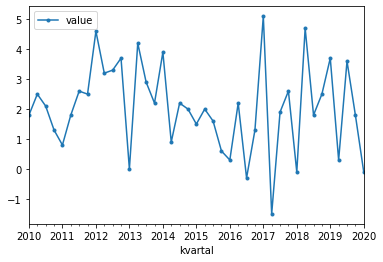

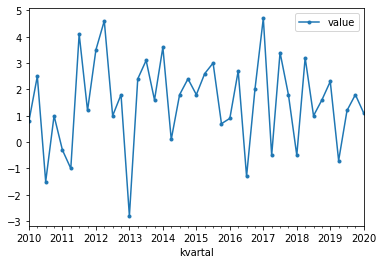

In [12]:
df1.groupby('makrostørrelse').plot( use_index=True, y='value', marker="o", markersize=3)

### pivoterer datasettet for å få èn figur

In [13]:
df2 = df1.pivot(columns = 'makrostørrelse', values='value')

Øker størrelsen og setter SSB-farger

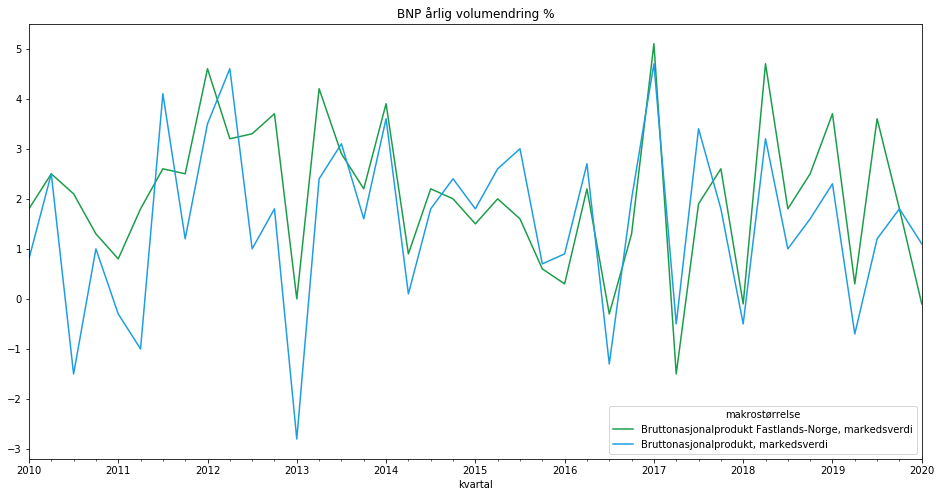

In [14]:
df2.plot(figsize=(16, 8), color=['#1a9d49', '#1d9de2'], title="BNP årlig volumendring %")